# Marketing Campaign

In [2]:
from IPython.display import Image

# Background Information

Personalized customer emails based off marketing analytics is a winning formula for many digital companies, and this is exactly the initiative that the leadership team at DVD Rental Co has decided to tackle!

We have been asked to support the customer analytics team at DVD Rental Co who have been tasked with generating the necessary data points required to populate specific parts of this first-ever customer email campaign.

## Email Template

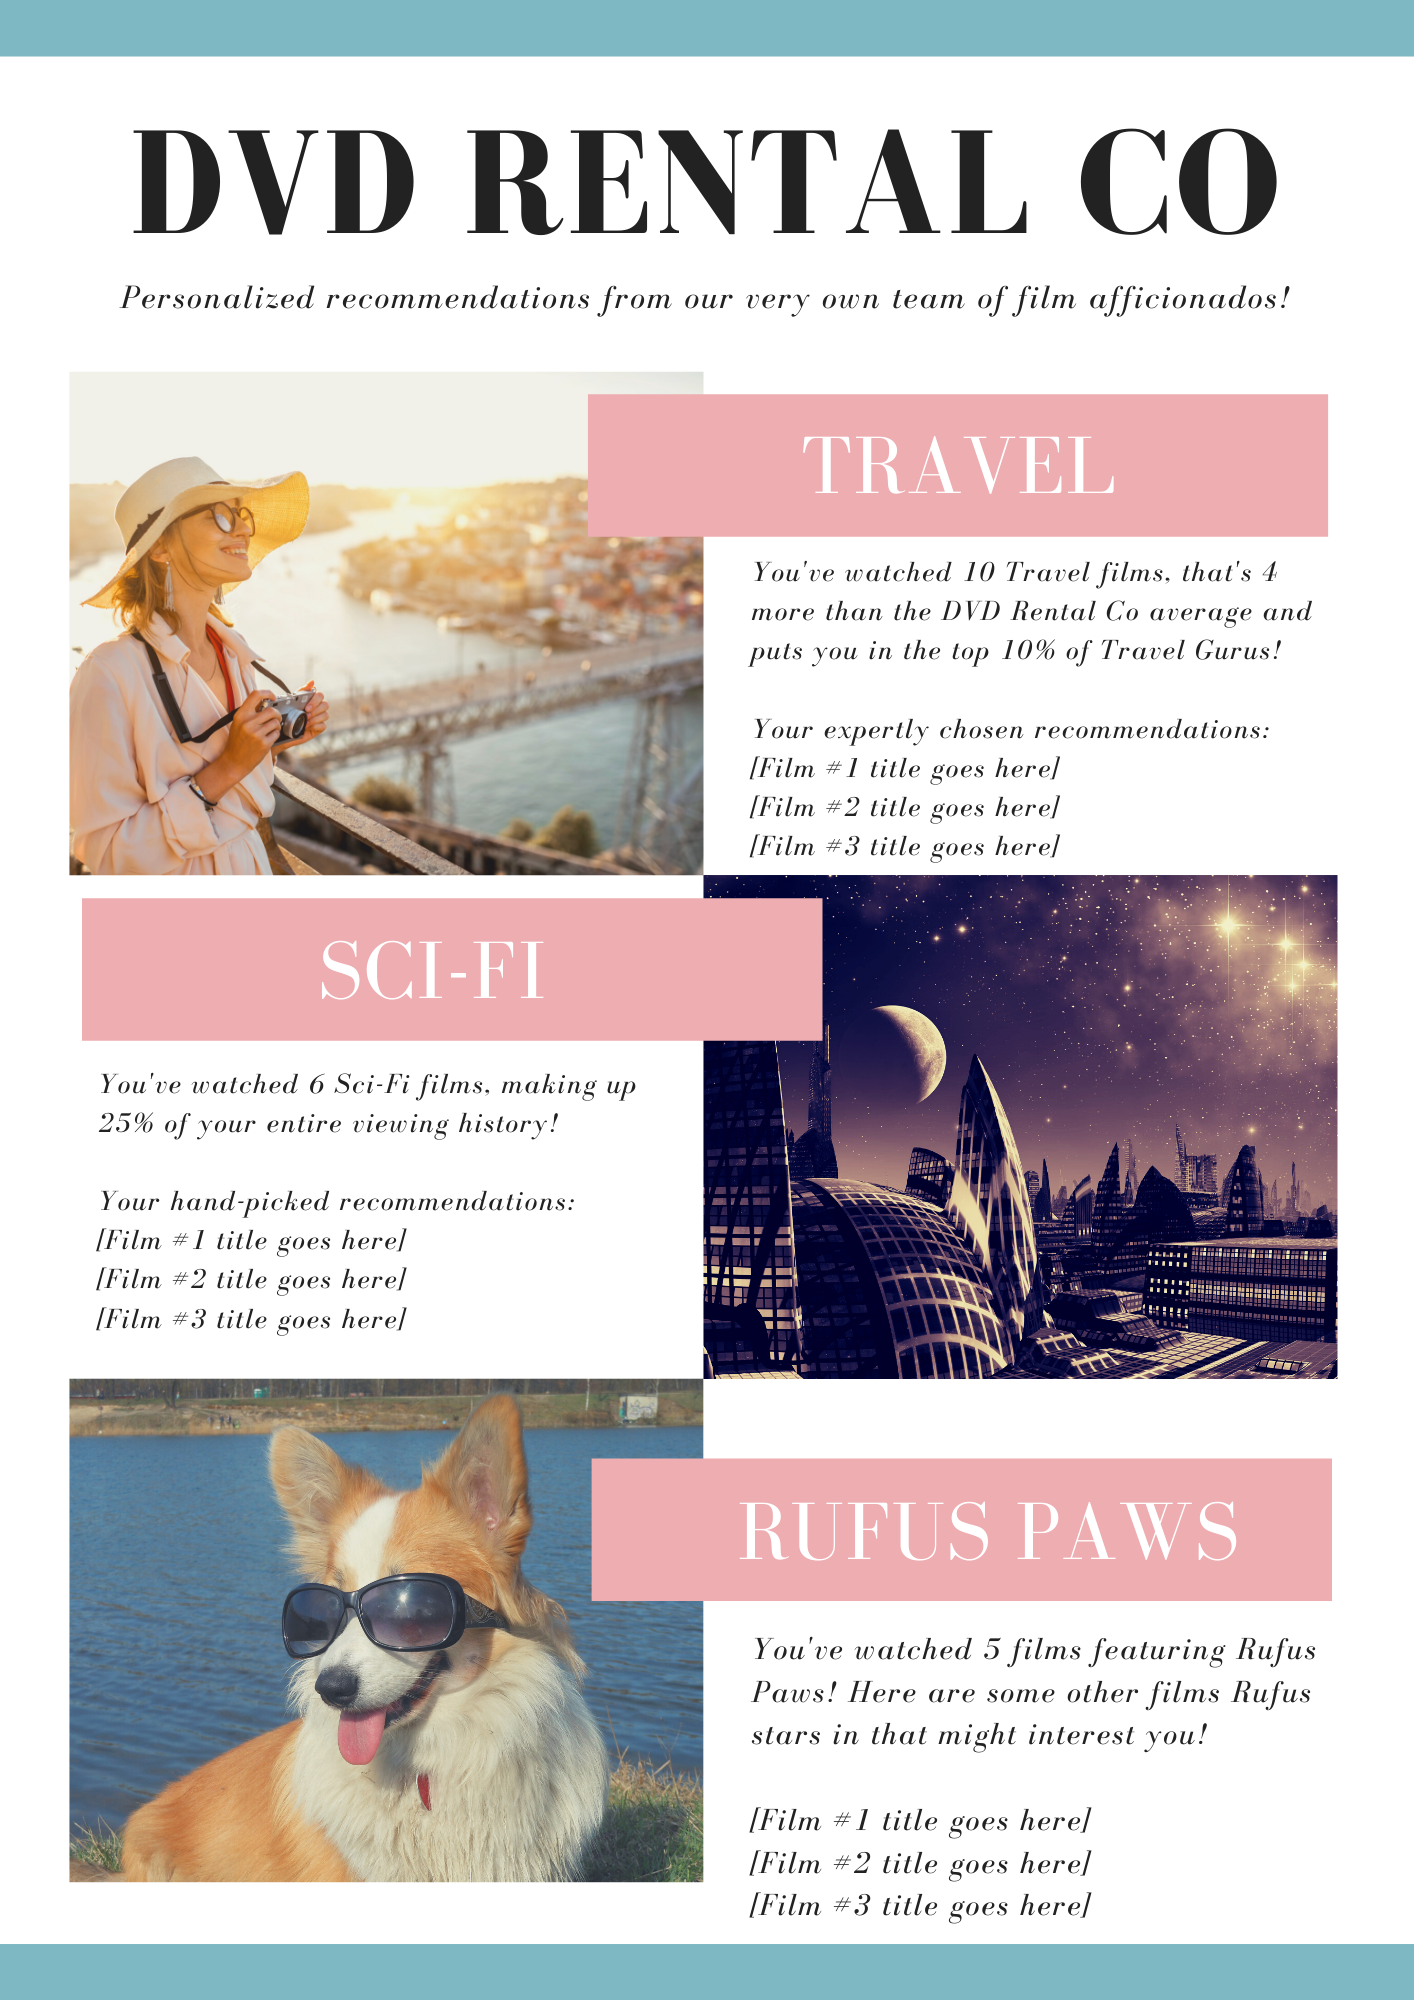

In [5]:
Image(filename="./resources/email-template.png", width=550)

## Requirements

1. ```Top 2 Categories```
   - For each customer, we need to identify the top 2 categories based off their past rental history. These top categories will drive marketing creative images as seen in the travel and sci-fi examples in the draft email.
***
2. ```Category Film Recommendations```
   - The marketing team has also requested for the 3 most popular films for each customer’s top 2 categories.
   - we cannot recommend a film which the customer has already viewed.
   - If there are less than 3 films available - marketing is happy to show at least 1 film.
   - Any customer which do not have any film recommendations for either category must be flagged out so the marketing team can exclude from the email campaign this is of high importance!
***
3. ```Individual Customer Insights```
   - The number of films watched by each customer in their top 2 categories is required as well as some specific insights.
     
   - For the 1st category, the marketing requires the following insights (requirement 3):
        - How many total films have they watched in their top category?
        - How many more films has the customer watched compared to the average DVD Rental Co customer?
        - How does the customer rank in terms of the top X% compared to all other customers in this film category?

     
   - For the second ranking category (requirement 4):
        - How many total films has the customer watched in this category?
        - What proportion of each customer’s total films watched does this count make?
***
4. ```Favorite Actor Recommendations```
    - Along with the top 2 categories, marketing has also requested top actor film recommendations where up to 3 more films are included in the recommendations list as well as the count of films by the top actor.

    - We have been given guidance by marketing to choose the actors in alphabetical order should there be any ties
    - in addition any films that have already been recommended in the top 2 categories must not be included as actor recommendations.
    - If the customer doesn’t have at least 1 film recommendation - they also need to be flagged with a separate actor exclusion flag.

# Dataset Overview

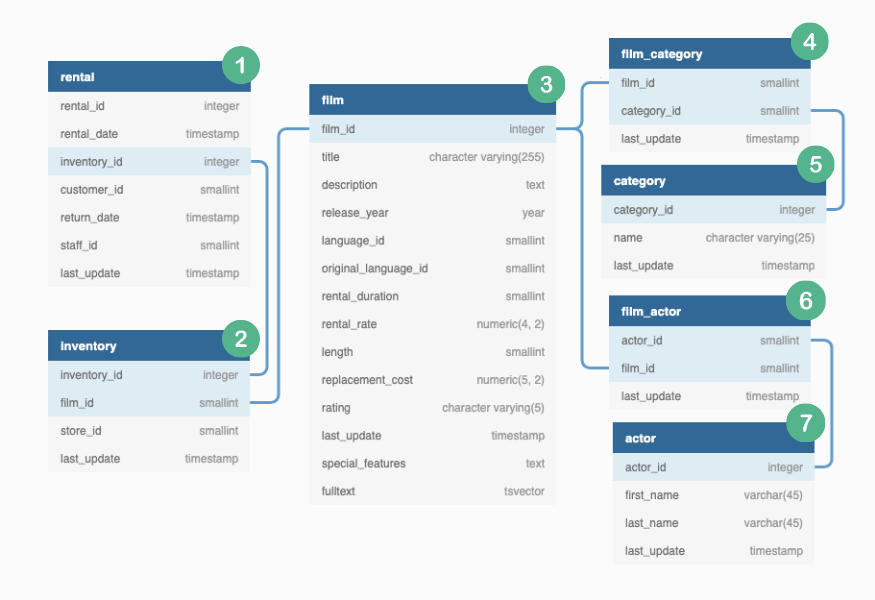

In [6]:
Image(filename="./resources/Marketing Campaign ERD.png")

# Open Analysis

**First, let's find out top 2 categories for each customers**

```Did customers rent the same film multiple times? If so, is it logical to add it to the total count or not?```

```sql
WITH cte_watched_multiple_times AS ( 
  SELECT
    t1.customer_id,
    COUNT(*) AS total_rentals,
    COUNT(DISTINCT film_id) AS unique_films_watched
  FROM 
    dvd_rentals.rental AS t1
    INNER JOIN 
    dvd_rentals.inventory AS t2
    ON
    t1.inventory_id = t2.inventory_id
  GROUP BY t1.customer_id
)
SELECT *
FROM cte_watched_multiple_times
ORDER BY customer_id
```

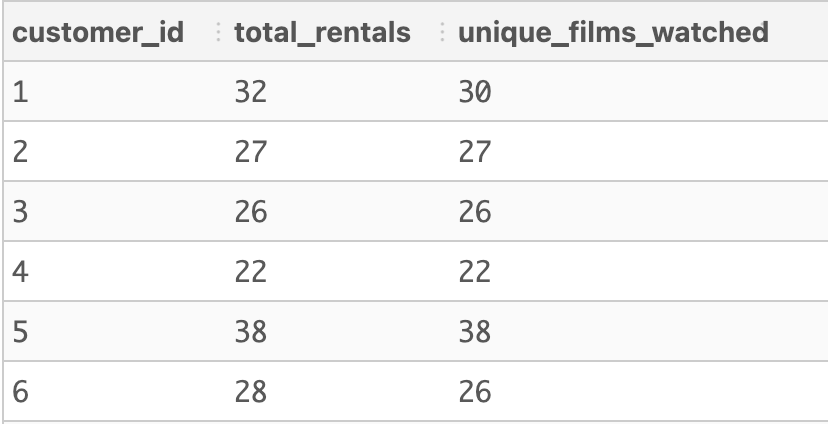

In [28]:
Image(filename="./resources/ma-insights-6.png", width=600)

From the above output we can clearly see that some customers have indeed watched the same film multiple times. If they are renting/ watching the same film multiple time it indicates they like this film/ category, it adds more weight to a certain category. I have taken the decision to take these duplicates into consideration also by using ```COUNT(*)``` instead for using ```COUNT(DISTINCT )```. In reality, this is something that should be discussed with the business team prior to analysis. i.e. What defines someone whatching a film?

Before we join tables, lets inspect the inventory table

```sql
SELECT *
FROM dvd_rentals.inventory
WHERE film_id = 1;
```

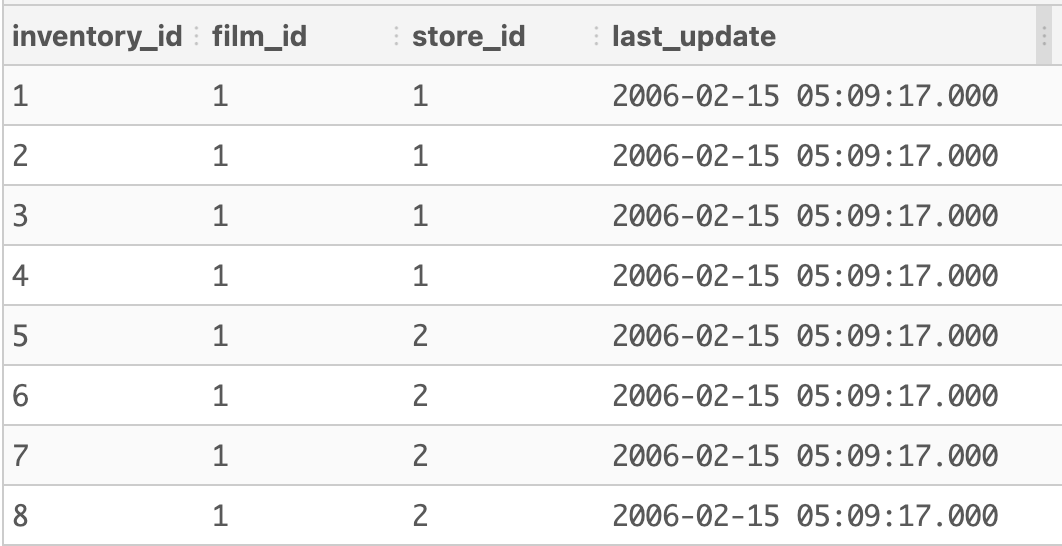

In [27]:
Image(filename="./resources/ma-insights-7.png", width=500)

From the above output we can see that DVD Rental Co has 2 stores, each having multiple copies of the same film BUT across both stores the inventory_id is unique acting as the ```PRIMARY KEY``` for this table.

```sql
WITH cte_category_counts AS ( 
  -- for each customer,we count how many films they have watched in each category 
  SELECT
    t1.customer_id,
    t4.name AS category_name,
    COUNT(*) films_watched,
    MAX(rental_date) AS latest_rental_date -- helps us deal with ties in categories acts as a recency metric
  FROM 
    dvd_rentals.rental AS t1
    INNER JOIN 
    dvd_rentals.inventory AS t2
    ON
    t1.inventory_id = t2.inventory_id
    INNER JOIN
    dvd_rentals.film_category t3
    ON t2.film_id = t3.film_id
    INNER JOIN
    dvd_rentals.category t4
    ON t3.category_id = t4.category_id
  GROUP BY t1.customer_id, t4.name
), 
ranked_categories AS (
  -- ranking the categories for each customers from most to least watched
  SELECT 
    customer_id,
    category_name,
    films_watched,
    ROW_NUMBER() OVER(PARTITION BY customer_id ORDER BY films_watched DESC, latest_rental_date DESC) category_ranking
  FROM cte_category_counts
)
```

The reason for using for ```ROW_NUMBER()``` instead of RANK() OR DENSE_RANK() is that some customers have watched the same amount of films for different categories. ROW_NUMBER() solves this problem and allows us to extract the top two categories for each customer. Below is an example of a customer and their category wise counts. We observe that this customers' top two categories have the same number of films watched.

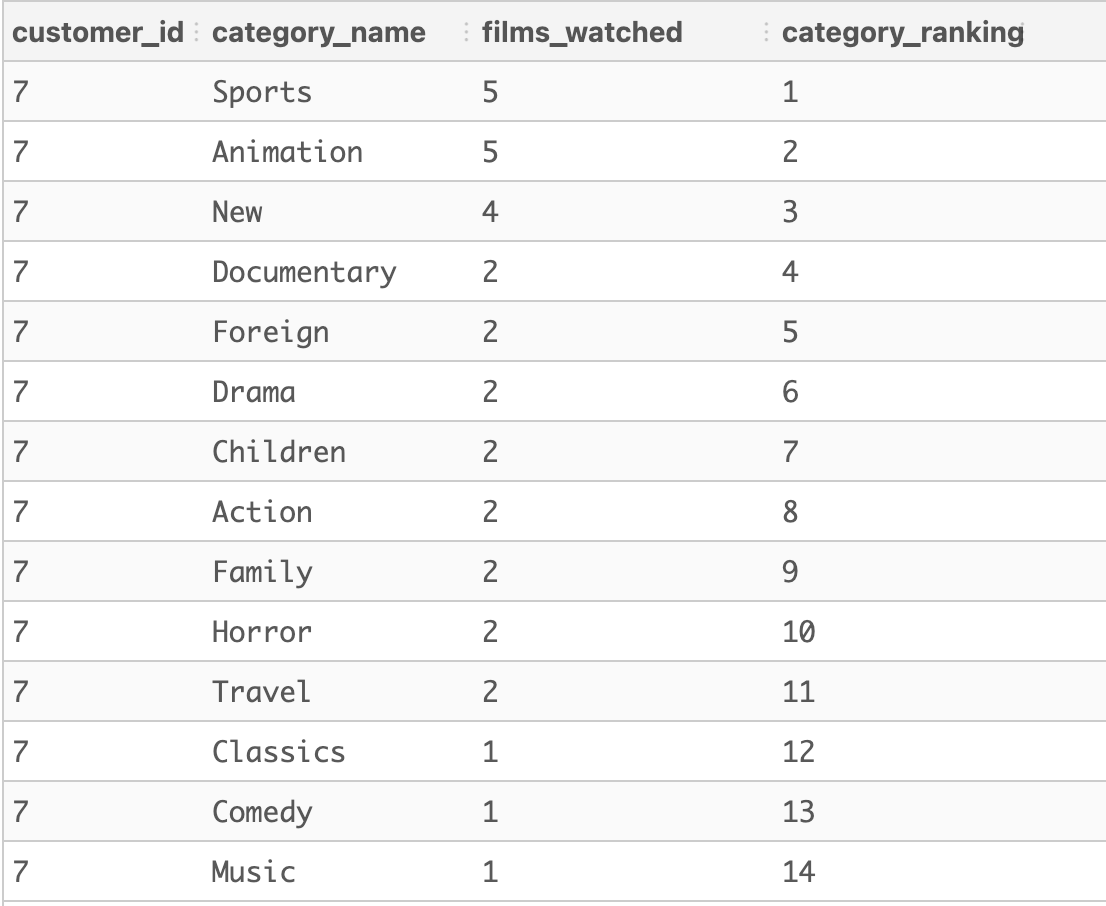

In [3]:
Image(filename="./resources/ma-insights-1.png", width=400)

```sql
top_category AS (
  -- contains most watched category for each customer
  SELECT 
    customer_id,
    category_name AS cat_1,
    films_watched AS cat_1_count
  FROM ranked_categories
  WHERE category_ranking = 1
),
second_category AS (
  -- contains 2nd most watched category for each customer
  SELECT 
    customer_id,
    category_name AS cat_2,
    films_watched AS cat_2_count
  FROM ranked_categories
  WHERE category_ranking = 2
)
SELECT
  t1.customer_id,
  t1.cat_1,
  t1.cat_1_count,
  t2.cat_2,
  t2.cat_2_count
FROM 
  top_category t1
  INNER JOIN
  second_category t2
  ON t1.customer_id = t2.customer_id
ORDER BY t1.customer_id;
```

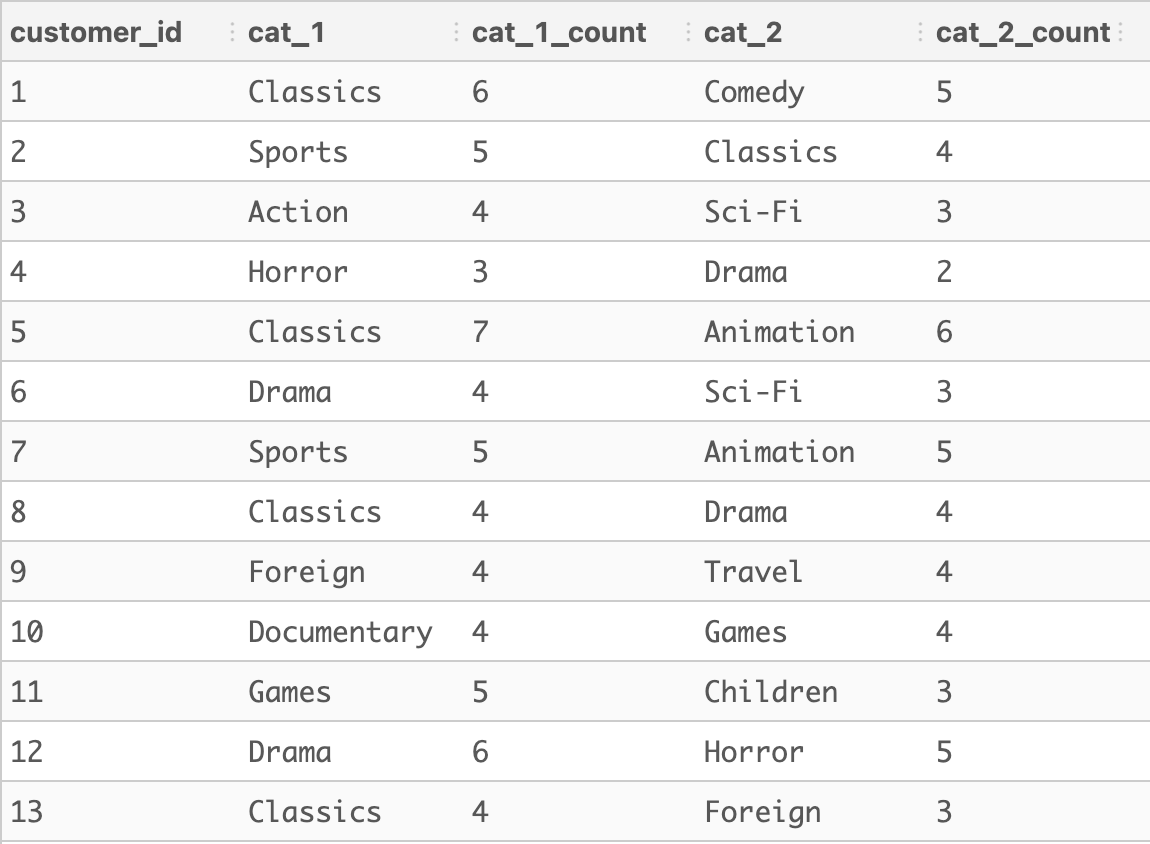

In [4]:
Image(filename="./resources/ma-insights-2.png", width=500)

**Let's dive into individual customer insights**

```sql
WITH cte_category_counts AS ( 
  -- for each customer,we count how many films they have watched in each category 
  SELECT
    t1.customer_id,
    t4.name AS category_name,
    COUNT(*) films_watched,
    MAX(rental_date) AS latest_rental_date -- helps us deal with ties in categories acts as a recency metric
  FROM 
    dvd_rentals.rental AS t1
    INNER JOIN 
    dvd_rentals.inventory AS t2
    ON
    t1.inventory_id = t2.inventory_id
    INNER JOIN
    dvd_rentals.film_category t3
    ON t2.film_id = t3.film_id
    INNER JOIN
    dvd_rentals.category t4
    ON t3.category_id = t4.category_id
  GROUP BY t1.customer_id, t4.name
), 
ranked_categories AS (
  -- ranking the categories for each customers from most to least watched
  SELECT 
    customer_id,
    category_name,
    films_watched,
    ROW_NUMBER() OVER(PARTITION BY customer_id ORDER BY films_watched DESC, latest_rental_date DESC) category_ranking
  FROM cte_category_counts
),
category_averages AS (
  -- calculate average films watched/ rented category wise
  SELECT 
  category_name,
  FLOOR(AVG(films_watched)) AS category_avg -- using floor gives customers a bit of a feel-good boost that they watch more films
  from cte_category_counts
  group by category_name 
),
total_films_watched AS(
  SELECT 
    customer_id,
    SUM(films_watched) AS total_watched
  FROM cte_category_counts
  GROUP BY customer_id
),
cte_top_n AS (
  SELECT 
    customer_id,
    category_name,
    CEILING( 100* (1 -  CUME_DIST() OVER(PARTITION BY category_name ORDER BY films_watched ASC))) AS top_n
  FROM cte_category_counts
),
final_query AS (
  SELECT
    t1.customer_id,  
    t1.category_ranking,
    t1.category_name,
    t1.films_watched,
    t1.films_watched - t2.category_avg AS average_comparison,
    t4.top_n,
    ROUND(100 * t1.films_watched::NUMERIC / t3.total_watched) AS category_percentage
  FROM 
    ranked_categories t1
    INNER JOIN
    category_averages t2
      ON t1.category_name = t2.category_name
    INNER JOIN
    total_films_watched t3
      ON t1.customer_id = t3.customer_id
    INNER JOIN
    cte_top_n t4
      ON t1.customer_id = t4.customer_id AND t1.category_name = t4.category_name
  WHERE category_ranking <= 2
  ORDER BY customer_id, category_ranking
)

```

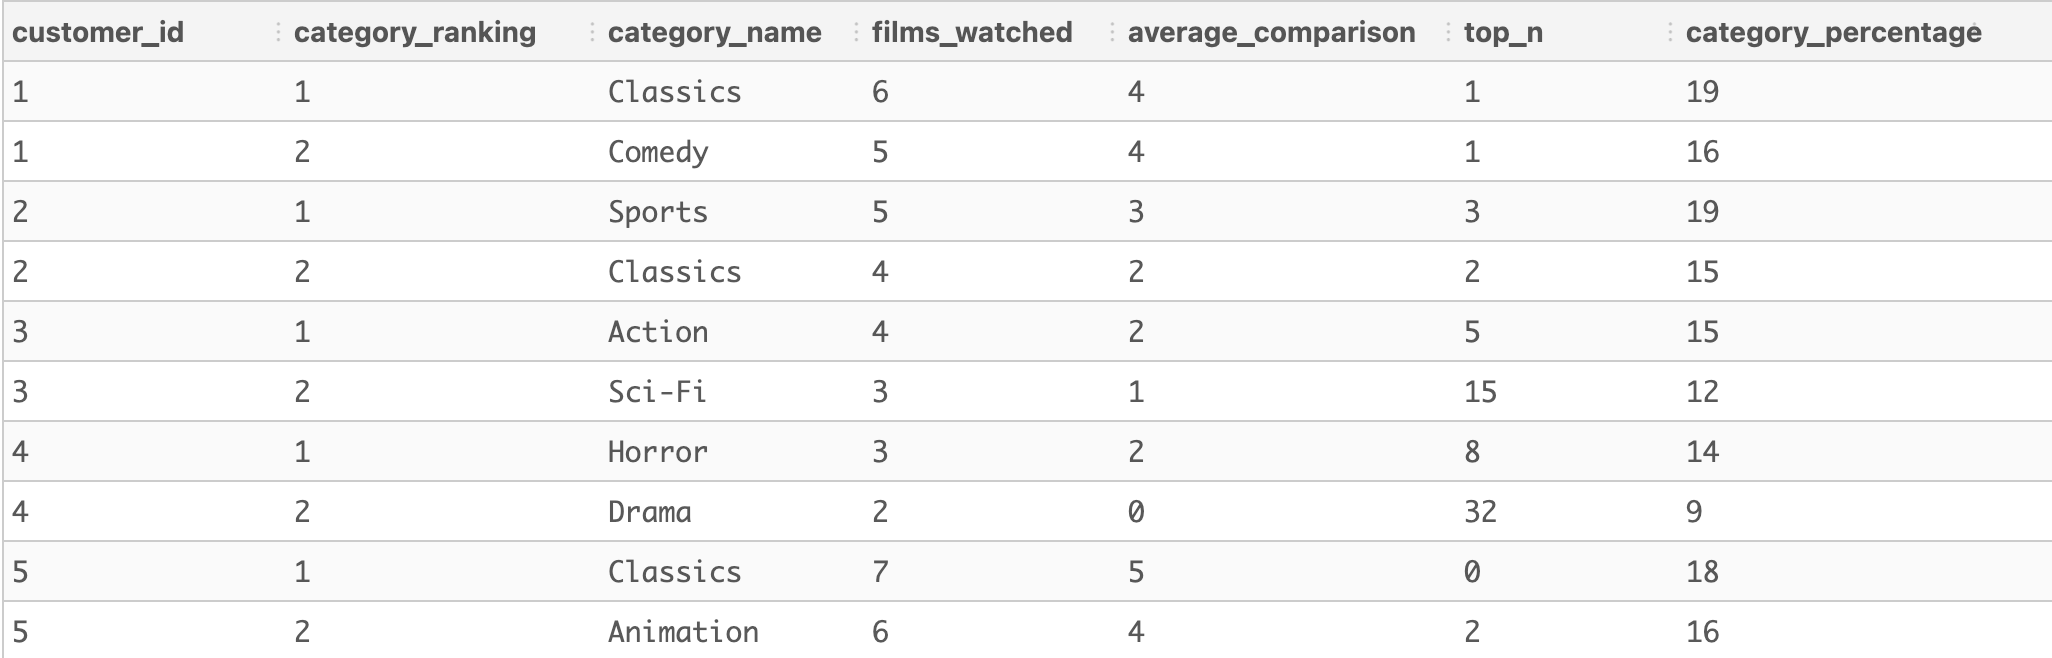

In [10]:
Image(filename="./resources/ma-insights-3.png", width=800)

In the above query, we output the top 2 categories for each customer, the number of films watched in the respective categories along with some additional insights.

Out of curiosity, I ran the below query to check if there are customers who have a 0 value in average_comparison or top_percentile columns.

```sql
SELECT DISTINCT customer_id 
FROM final_query
WHERE 
  (average_comparison <= 0 OR top_n <= 0)
  AND
  category_ranking = 1;
```

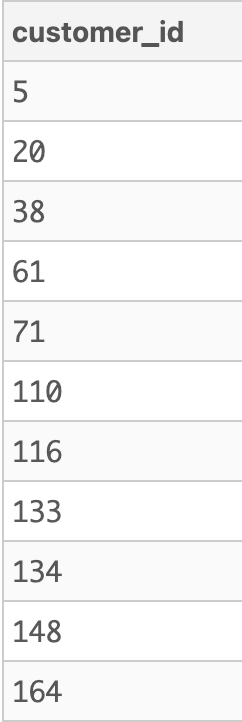

In [11]:
Image(filename="./resources/ma-insights-4.png", width=200)

Above output is just a sample, in total we have 37 customers who have a 0 value in average_comparison or top_n columns even after rounding. As per the email template, for each customer's top category we need to display how they compare with the average and how they rank among the top. **We wouldn't want to tell the customer that they have watched below, exactly average or rank among the top 0% do we? We should exclude these customers in the email campaign.**

# Key Takeaways

```Deciding Which Type of Table Joins to Use```
 - What is the purpose of joining these two tables?
 - How many unique foreign key values exist in each table?
 - What is the distribution of foreign keys within each table? How many records exist per foreign key value in left and right tables?
    - A double aggregation will give more insights
    - The distribution and relationship within the table by the foreign keys is super important because it helps us inspect what our table joining inputs  consist of and also determines what sort of outputs we should expect after joining.
    - 1:1 | 1:many | many:1 | many:many
 - How many overlapping and missing unique foreign key values are there between the two tables?
   - Foreign key values that only exists in left table (anti-join)
   - Foreign key values that only exists in right table (anti-join)
   - Foreign key values that only exists in both tables (left semi join)
- The most important thing when gauging the types of joins you should use is that relationship between the foreign keys and the target tables.

```Dealing With Ties```
 - Sort the values further by an additional condition or criteria
 - you do not want to randomly select single rows as this is not reproducible

```Thinking through customer experience when we make technical decisions that might negatively impact a message or insight```